In [1]:
# Author - Ritvik Khanna 
# Date - 04/05/18 
# Version - 2.3


import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pandas as pd
from sklearn.datasets import load_iris
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt #importing graph plotting functionality
# import os
# print(os.listdir("../input"))
# Load dataset
df = pd.read_csv("Datasets/car_evaluation.csv", names = ["buying","maint", "doors", "persons", "lug_boot","safety","class"])

## Preprocessing the data

Here, the dataset contains of 6 attributes and 1 class column having 4 class values{unacc, acc, good, vgood}. As we are building a neural network we need to provide the neural node values it can read and not bias over a specific value of an attribute. Therefore we convert all the nominal/categorical data into numeric by using **pandas.get_dummies** function. This function will create additional columns of each values corresponding to each attribute, therefore increasing the number of total columns.

In [2]:
## get_dummies() implementation
category_col =["buying","maint", "doors", "persons", "lug_boot","safety","class"] 
df = pd.get_dummies(df, columns=category_col)
df.to_csv('Datasets/car_evaluation_preprocessed.csv',index=False)
## visualizing processed dataset
print(df.shape)
df.head(10)

(1728, 25)


,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med,class_acc,class_good,class_unacc,class_vgood
0,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,1,0,0,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,0,1,0,0,1,0
2,0,0,0,1,0,0,0,1,1,0,...,0,0,1,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,1,0,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
5,0,0,0,1,0,0,0,1,1,0,...,0,1,0,1,0,0,0,0,1,0
6,0,0,0,1,0,0,0,1,1,0,...,1,0,0,0,1,0,0,0,1,0
7,0,0,0,1,0,0,0,1,1,0,...,1,0,0,0,0,1,0,0,1,0
8,0,0,0,1,0,0,0,1,1,0,...,1,0,0,1,0,0,0,0,1,0
9,0,0,0,1,0,0,0,1,1,0,...,0,0,1,0,1,0,0,0,1,0


#### Dividing the dataset into Attribute and labels, then spliting into train and test using crossvalidation

In [3]:
X = df.iloc[:, 0:21].values
y = df.iloc[:, 21:].values
## Normalizing data - Normalization refers to rescaling real valued numeric attributes into the range 0 and 1.
X = preprocessing.scale(X)
from sklearn.model_selection import train_test_split
feature_train, feature_test, labels_train, labels_test = train_test_split(X, y, random_state = 42)
print ("Train:%d +  Test:%d = Total:%d"  % (len(feature_train),len(feature_test),len(feature_train)+len(feature_test)))

Train:1296 +  Test:432 = Total:1728


/Users/ritvikkhanna/VirtualEnvironments/PyTorch/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


## Building the NN classifier using PyTorch

In [4]:
feature_train_v = Variable(torch.FloatTensor(feature_train), requires_grad = False)
labels_train_v = Variable(torch.FloatTensor(labels_train), requires_grad = False)
feature_test_v = Variable(torch.FloatTensor(feature_test), requires_grad = False)
labels_test_v = Variable(torch.FloatTensor(labels_test), requires_grad = False)

class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.h_layer = nn.Linear(21, 4) #21 input layers and 4 output layers
        self.s_layer = nn.Softmax()
    def forward(self,x):
        y = self.h_layer(x)
        p = self.s_layer(y)
        return p
#declaring the classifier to an object
model = LinearClassifier()   
#calculates the loss
loss_fn = nn.BCELoss()       
optim = torch.optim.SGD(model.parameters(), lr = 0.01)

#### Now we fit the raining data into the model, here we do 5000 iterations and collect the loss of each iteration

In [5]:
all_losses = []
for num in range(5000): 
    pred = model(feature_train_v) #predict
    loss = loss_fn(pred, labels_train_v) #calculate loss
    all_losses.append(loss.data)
    optim.zero_grad() #zero gradients to not accumulate
    loss.backward() #update weights based on loss
    optim.step() #update optimiser for next iteration

/Users/ritvikkhanna/VirtualEnvironments/PyTorch/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


## Visualizing the loss per each iteration

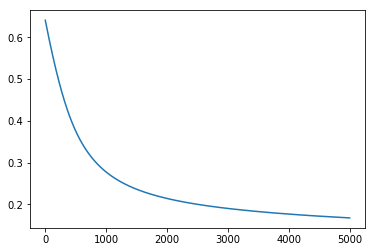

tensor([ 0.4646,  0.0828,  0.4012,  0.0514])
tensor([ 1.,  0.,  0.,  0.])
0.16767245531082153


In [6]:
all_losses = np.array(all_losses, dtype = np.float)
all_losses
plt.plot(all_losses)
plt.show()
print(pred[3])
print(labels_train_v[3])
print(all_losses[-1])

## Accuracy result from testing data on the model

Now we fit the test dataset on our model and find the score of each correctly labeled data by the Neural Network model and find the accuracy.

In [7]:
from sklearn.metrics import accuracy_score
predicted_values = []
for num in range(len(feature_test_v)):
    predicted_values.append(model(feature_test_v[num]))

    
    score = 0
for num in range(len(predicted_values)):
    if np.argmax(labels_test[num]) == np.argmax(predicted_values[num].data.numpy()):
        score = score + 1
accuracy = float(score / len(predicted_values)) * 100
print ('Testing Accuracy Score is ' + str(accuracy))

Testing Accuracy Score is 86.3425925925926


/Users/ritvikkhanna/VirtualEnvironments/PyTorch/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
